# **Introduction**
New and novel methods in Machine Learning are made either by borrowing formulas and concepts from other scientific fields and redefining it based on new sets of assumptions, or by adding an extra step to an already existing framework of methodology.

In this exercise, we will try to develop a novel method of Target Trial Emulation by integrating concepts of Clustering into the already existing framework. Target Trial Emulation is a new methodological framework in epidemiology which tries to account for the biases in old and traditional designs.

## **Trial Sequence Analysis**
This notebook implements a `TrialSequence` class to perform a trial sequence analysis with inverse probability weighting (IPW) for treatment switching and censoring, followed by fitting a marginal structural model (MSM). The code simulates data if none is provided and demonstrates the full workflow from data preparation to inference and visualization.

## **References**
- https://rpubs.com/alanyang0924/TTE

In [2]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import pickle
import matplotlib.pyplot as plt
import warnings

# Suppress FutureWarning for cleaner output
warnings.filterwarnings("ignore", category=FutureWarning)

# **Step 1: Data Preparation**
Loads the dataset (data_censored.csv) or generates simulated data if unavailable. It constructs patient-level and time-varying covariates, treatment assignments, outcomes, and censoring indicators to ensure a structured dataset for Target Trial Emulation (TTE).

In [3]:
try:
    data_censored = pd.read_csv("../data/data_censored.csv")
    data_censored["previous_treatment"] = data_censored["treatment"].shift(1).fillna(0)
except FileNotFoundError:
    np.random.seed(42)
    n_patients = 89
    n_periods = 8
    data_censored = pd.DataFrame({
        'id': np.repeat(range(1, n_patients + 1), n_periods),
        'period': np.tile(range(n_periods), n_patients),
        'treatment': np.random.binomial(1, 0.5, n_patients * n_periods),
        'x1': np.random.binomial(1, 0.5, n_patients * n_periods),
        'x2': np.random.normal(0, 1, n_patients * n_periods),
        'x3': np.random.binomial(1, 0.3, n_patients * n_periods),
        'x4': np.random.uniform(0, 1, n_patients * n_periods),
        'age': np.repeat(np.random.randint(30, 80, n_patients), n_periods),
        'age_s': np.tile(np.linspace(0, 3, n_periods), n_patients),
        'outcome': np.random.binomial(1, 0.1, n_patients * n_periods),
        'censored': np.random.binomial(1, 0.2, n_patients * n_periods),
        'eligible': np.random.binomial(1, 0.5, n_patients * n_periods)
    })
    print("Warning: data_censored.csv not found. Using simulated data.")

## **TrialSequence Class Definition**
The `TrialSequence` class encapsulates the logic for trial sequence analysis, including weight model fitting, trial expansion, MSM fitting, and prediction. Below is the complete class definition.

In [4]:
class TrialSequence:
    def __init__(self, estimand):
        self.estimand = estimand
        self.data = None
        self.switch_config = {}
        self.censor_config = {}
        self.switch_models = {}
        self.censor_models = {}
        self.outcome_model = {}
        self.expansion_options = {}
        self.expanded_data = None
        self.fitted_msm = None
        self.directory = None
        self.columns = {}
        self.sample_prob = None

    def set_data(self, data, id_col, period_col, treatment_col, outcome_col, eligible_col, extra_cols=None):
        if extra_cols:
            columns = [id_col, period_col, treatment_col, outcome_col, eligible_col] + extra_cols
        else:
            columns = data.columns.tolist()
        self.data = data[columns].copy()
        self.columns = {"id": id_col, "period": period_col, "treatment": treatment_col, 
                        "outcome": outcome_col, "eligible": eligible_col}
        return self

    def set_weight_models(self, weight_type, censor_event=None, numerator_vars=None, denominator_vars=None, pool_models="none", save_path=None):
        config_key = f"{weight_type}_config"
        self.__dict__[config_key] = {
            "censor_event": censor_event,
            "numerator_vars": numerator_vars,
            "denominator_vars": denominator_vars,
            "pool_models": pool_models,
            "save_path": save_path,
            "fitted": False
        }
        return self

    def fit_weight_models(self, weight_type):
        config = self.__dict__[f"{weight_type}_config"]
        data = self.data.copy()
        models = {}
        
        # Add previous treatment
        data['prev_treatment'] = data.groupby(self.columns['id'])[self.columns['treatment']].shift(1).fillna(0)
        
        if weight_type == "censor":
            outcome = config["censor_event"]
            data[outcome] = 1 - data[outcome]  # Invert censor event
            
            if self.estimand == "PP":
                # Identify treatment switches for PP
                data['switched'] = (data[self.columns['treatment']] != data['prev_treatment']) & (data['prev_treatment'].notna())
                # Keep only observations up to the first switch
                data['switch_cumsum'] = data.groupby(self.columns['id'])['switched'].cumsum()
                data = data[data['switch_cumsum'] == 0].copy()  # Exclude post-switch observations
            
            if self.estimand == "ITT" and config["pool_models"] == "numerator":
                formula_num = f"{outcome} ~ {' + '.join(config['numerator_vars'])}"
                model_num = smf.glm(formula_num, data=data, family=sm.families.Binomial()).fit()
                models["pooled"] = {"numerator": model_num}
                for group_name, group_data in data.groupby('prev_treatment'):
                    formula_den = f"{outcome} ~ {' + '.join(config['denominator_vars'])}"
                    model_den = smf.glm(formula_den, data=group_data, family=sm.families.Binomial()).fit()
                    models[int(group_name)] = {"denominator": model_den}
            else:  # PP estimand or no pooling
                groups = data.groupby('prev_treatment')
                formula_num = f"{outcome} ~ {' + '.join(config['numerator_vars'])}"
                formula_den = f"{outcome} ~ {' + '.join(config['denominator_vars'])}"
                for group_name, group_data in groups:
                    model_num = smf.glm(formula_num, data=group_data, family=sm.families.Binomial()).fit()
                    model_den = smf.glm(formula_den, data=group_data, family=sm.families.Binomial()).fit()
                    models[int(group_name)] = {"numerator": model_num, "denominator": model_den}
        
        elif weight_type == "switch":
            data['prev_treatment'] = data.groupby(self.columns['id'])[self.columns['treatment']].shift(1).fillna(0)
            groups = data.groupby('prev_treatment')
            outcome = self.columns['treatment']
            formula_num = f"{outcome} ~ {' + '.join(config['numerator_vars'])}"
            formula_den = f"{outcome} ~ {' + '.join(config['denominator_vars'])}"
            for group_name, group_data in groups:
                model_num = smf.glm(formula_num, data=group_data, family=sm.families.Binomial()).fit()
                model_den = smf.glm(formula_den, data=group_data, family=sm.families.Binomial()).fit()
                models[int(group_name)] = {"numerator": model_num, "denominator": model_den}
        
        if config["save_path"]:
            os.makedirs(config["save_path"], exist_ok=True)
            for group_name, model_dict in models.items():
                for model_type, model in model_dict.items():
                    with open(os.path.join(config["save_path"], f"model_{weight_type}_{group_name}_{model_type[0]}.pkl"), 'wb') as f:
                        pickle.dump(model, f)
        
        self.__dict__[f"{weight_type}_models"] = models
        config["fitted"] = True
        return self

    def calculate_weights(self, weight_type):
        config = self.__dict__[f"{weight_type}_config"]
        if not config["fitted"]:
            self.fit_weight_models(weight_type)
        
        data = self.data.copy()
        models = self.__dict__[f"{weight_type}_models"]
        
        if 'prev_treatment' not in data.columns:
            data['prev_treatment'] = data.groupby(self.columns['id'])[self.columns['treatment']].shift(1).fillna(0)
        
        if weight_type == "censor" and self.estimand == "ITT" and config["pool_models"] == "numerator":
            prob_num = models["pooled"]["numerator"].predict(data)
            for prev_treatment in [0, 1]:
                group_data = data[data['prev_treatment'] == prev_treatment]
                idx = group_data.index
                prob_den = models[prev_treatment]["denominator"].predict(group_data)
                weight = prob_num.loc[idx] / prob_den
                data.loc[idx, f"{weight_type}_weight"] = weight
        else:  # PP estimand or no pooling
            for group_name, model_dict in models.items():
                group_data = data[data['prev_treatment'] == group_name]
                idx = group_data.index
                prob_num = model_dict["numerator"].predict(group_data)
                prob_den = model_dict["denominator"].predict(group_data)
                weight = prob_num / prob_den  # Stabilized weight for censoring
                data.loc[idx, f"{weight_type}_weight"] = weight
        
        self.data = data
        return self

    def stabilize_weights(self, weight_col, group_col=None):
        """
        Stabilize weights by dividing them by the mean weight within each group.

        Args:
            weight_col (str): The column name of the weights to stabilize.
            group_col (str, optional): The column name to group by for stabilization.
                                      If None, weights are stabilized globally.
        """
        if weight_col not in self.data.columns:
            raise ValueError(f"Weight column '{weight_col}' not found in data.")
        
        if group_col is None:
            # Stabilize globally (no grouping)
            mean_weight = self.data[weight_col].mean()
            self.data[f"{weight_col}_stabilized"] = self.data[weight_col] / mean_weight
        else:
            if group_col not in self.data.columns:
                raise ValueError(f"Group column '{group_col}' not found in data.")
            # Stabilize within each group
            self.data[f"{weight_col}_stabilized"] = self.data.groupby(group_col)[weight_col].transform(
                lambda x: x / x.mean()
            )
        return self

    def show_weight_models(self):
        
        for weight_type in ["switch", "censor"]:
            if f"{weight_type}_models" not in self.__dict__:
                continue
            print(f"## Weight Models for {'Treatment Switching' if weight_type == 'switch' else 'Informative Censoring'}")
            print("## ---------------------------------------\n")
            models = self.__dict__[f"{weight_type}_models"]
            for group_name, model_dict in models.items():
                group_label = str(int(group_name)) if isinstance(group_name, (int, float)) else group_name
                for model_type, model in model_dict.items():
                    if weight_type == "switch":
                        label = f"[[{model_type[0]}{group_label}]]"
                        desc = f"P(treatment = 1 | previous treatment = {group_label})"
                    else:
                        label = f"[[{model_type[0]}{group_label}]]"
                        desc = f"P(censor_event = 0 | X, previous treatment = {group_label})"
                    print(label)
                    print(f"## Model: {desc} for {model_type}")
                    print("##  ")
                    print("##  term        estimate   std.error statistic p.value")
                    coef_table = model.summary2().tables[1]
                    for idx, row in coef_table.iterrows():
                        print(f"##  {idx:<12} {row['Coef.']:.7f} {row['Std.Err.']:.7f} {row['z']:.6f} {row['P>|z|']:.6e}")
                    print("##  ")
                    print("##  null.deviance df.null logLik    AIC      BIC      deviance df.residual nobs")
                    bic = model.aic + (len(coef_table) - 1) * np.log(model.nobs)
                    print(f"##  {model.null_deviance:.4f}      {model.df_model + model.df_resid:.0f}     {model.llf:.4f} {model.aic:.4f} {bic:.4f} {model.deviance:.4f} {model.df_resid:.0f}         {model.nobs:.0f}")
                    print("##  ")

    def set_outcome_model(self, adjustment_terms=None):
        base_formula = "outcome ~ assigned_treatment + followup_time + I(followup_time**2) + trial_period + I(trial_period**2)"
        if adjustment_terms:
            self.outcome_model['formula'] = f"{base_formula} + {adjustment_terms.strip('~')}"
            self.outcome_model['adjustment_terms'] = adjustment_terms.strip('~')
        else:
            self.outcome_model['formula'] = base_formula
            self.outcome_model['adjustment_terms'] = None
        self.outcome_model['treatment_var'] = "assigned_treatment"
        return self

    def set_expansion_options(self, output_path, chunk_size):
        self.expansion_options = {'output_path': output_path, 'chunk_size': chunk_size}
        return self

    def expand_trials(self):
        expanded = []
        for trial_period in self.data['period'].unique():
            trial_data = self.data[self.data['period'] >= trial_period].copy()
            trial_data['trial_period'] = trial_period
            trial_data['followup_time'] = trial_data['period'] - trial_period
            trial_data['assigned_treatment'] = trial_data['treatment']
            trial_data['weight'] = trial_data.get('censor_weight', 1.0) * trial_data.get('switch_weight', 1.0)
            expanded.append(trial_data)
        self.expanded_data = pd.concat(expanded, ignore_index=True)
        self.expanded_data.to_csv(self.expansion_options['output_path'], index=False)
        return self

    def load_expanded_data(self, seed=None, p_control=None):
        if seed is not None:
            np.random.seed(seed)
        if p_control is not None:
            self.sample_prob = p_control
            control_mask = (self.expanded_data['outcome'] == 0)
            sampled_controls = self.expanded_data[control_mask].sample(frac=p_control)
            cases = self.expanded_data[~control_mask]
            self.expanded_data = pd.concat([cases, sampled_controls], ignore_index=True)
            self.expanded_data['sample_weight'] = np.where(self.expanded_data['outcome'] == 0, 1/p_control, 1)
            self.expanded_data['w'] = self.expanded_data['weight'] * self.expanded_data['sample_weight']
        # Sort by id in ascending order
        self.expanded_data = self.expanded_data.sort_values(self.columns['id']).reset_index(drop=True)
        return self

    def fit_msm(self, weight_cols=None, modify_weights=None):
        if weight_cols is None:
            weight_cols = ['weight']
        weights = self.expanded_data[weight_cols[0]].copy()
        if modify_weights:
            weights = modify_weights(weights)
        self.fitted_msm = smf.glm(self.outcome_model['formula'], self.expanded_data, family=sm.families.Binomial(), freq_weights=weights).fit()
        return self

    def show_outcome_model(self):
        if self.fitted_msm is None:
            print("No fitted MSM available. Run fit_msm() first.")
            return
        
        print(f"- Formula: {self.outcome_model['formula']}")
        print(f"- Treatment variable: {self.outcome_model['treatment_var']}")
        print(f"- Adjustment variables: {self.outcome_model['adjustment_terms'] if self.outcome_model['adjustment_terms'] else 'None'}")
        print("- Model fitter type: te_stats_glm_logit")
        print("\nModel Summary:\n")
        
        coef_table = self.fitted_msm.summary2().tables[1]
        conf_int = self.fitted_msm.conf_int()
        
        print("term               estimate std.error statistic p.value conf.low conf.high")
        for idx, row in coef_table.iterrows():
            conf_low = conf_int.loc[idx, 0]
            conf_high = conf_int.loc[idx, 1]
            print(f"{idx:<19} {row['Coef.']:<8.2f} {row['Std.Err.']:<9.3f} {row['z']:<9.2f} {row['P>|z|']:<8.1e} {conf_low:<8.4f} {conf_high:<8.4f}")
        
        null_deviance = self.fitted_msm.null_deviance
        df_null = self.fitted_msm.df_model + self.fitted_msm.df_resid
        log_lik = self.fitted_msm.llf
        aic = self.fitted_msm.aic
        bic = aic + (len(coef_table) - 1) * np.log(self.fitted_msm.nobs)
        deviance = self.fitted_msm.deviance
        df_resid = self.fitted_msm.df_resid
        nobs = self.fitted_msm.nobs
        
        print("\nnull.deviance df.null logLik AIC BIC deviance df.residual nobs")
        print(f"{null_deviance:<14.0f} {df_null:<7.0f} {log_lik:<6.1f} {aic:<3.0f} {bic:<3.0f} {deviance:<7.0f} {df_resid:<11.0f} {nobs:<4.0f}")

    def show_trial_summary(self):
        print("## Trial Sequence Object")
        print(f"## Estimand: {self.estimand.capitalize()}-to-treat")
        print("## ")
        
        # Data Summary
        n_obs = len(self.data)
        n_patients = self.data['id'].nunique()
        print("## Data:")
        print(f"##  - N: {n_obs} observations from {n_patients} patients")
        data_cols = ['id', 'period', 'treatment', 'x1', 'x2', 'x3', 'x4', 'age', 'age_s', 'outcome', 'censored', 'eligible']
        print("##         id period treatment    x1           x2    x3        x4   age      age_s outcome censored eligible")
        print("##      <int>  <int>     <num> <num>        <num> <int>     <num> <num>      <num>   <num>    <int>    <num>")
        for i, row in self.data[data_cols].head(2).iterrows():
            print(f"##   {i+1}: {row['id']:<5} {row['period']:<6} {row['treatment']:<9.0f} {row['x1']:<4.0f} {row['x2']:<12.6f} {row['x3']:<5.0f} {row['x4']:<9.7f} {row['age']:<4.0f} {row['age_s']:<11.8f} {row['outcome']:<7.0f} {row['censored']:<8.0f} {row['eligible']:<4.0f}")
        print("##  ---")
        for i, row in self.data[data_cols].tail(2).iterrows():
            print(f"## {i+1:<3}: {row['id']:<5} {row['period']:<6} {row['treatment']:<9.0f} {row['x1']:<4.0f} {row['x2']:<12.6f} {row['x3']:<5.0f} {row['x4']:<9.7f} {row['age']:<4.0f} {row['age_s']:<11.8f} {row['outcome']:<7.0f} {row['censored']:<8.0f} {row['eligible']:<4.0f}")
        
        # IPW for Informative Censoring
        if 'censor_config' in self.__dict__:
            config = self.censor_config
            print("## ")
            print("## IPW for informative censoring:")
            print(f"##  - Numerator formula: 1 - {config['censor_event']} ~ {' + '.join(config['numerator_vars'])}")
            print(f"##  - Denominator formula: 1 - {config['censor_event']} ~ {' + '.join(config['denominator_vars'])}")
            if self.estimand == "ITT" and config["pool_models"] == "numerator":
                print("##  - Numerator model is pooled across treatment arms. Denominator model is not pooled.")
            print("##  - Model fitter type: te_stats_glm_logit")
            print("##  - View weight model summaries with show_weight_models()")
        
        # Sequence of Trials Data
        if self.expanded_data is not None:
            print("## ")
            print("## Sequence of Trials Data:")
            print(f"## - Chunk size: {self.expansion_options['chunk_size']}")
            print("## - Censor at switch: FALSE")
            print("## - First period: 0 | Last period: Inf")
            print("## ")
            print("## A TE Datastore Datatable object")
            n_obs_exp = len(self.expanded_data)
            print(f"## N: {n_obs_exp} observations")
            exp_cols = ['id', 'trial_period', 'followup_time', 'outcome', 'weight', 'treatment', 'x2', 'assigned_treatment']
            print("##          id trial_period followup_time outcome    weight treatment         x2 assigned_treatment")
            print("##       <int>        <int>         <int>   <num>     <num>     <num>      <num>             <num>")
            for i, row in self.expanded_data[exp_cols].head(2).iterrows():
                print(f"##   {i+1}: {row['id']:<5} {row['trial_period']:<12} {row['followup_time']:<13.0f} {row['outcome']:<7.0f} {row['weight']:<9.7f} {row['treatment']:<9.0f} {row['x2']:<12.7f} {row['assigned_treatment']:<8.0f}")
            print("##  ---")
            for i, row in self.expanded_data[exp_cols].tail(2).iterrows():
                print(f"## {i+1:<3}: {row['id']:<5} {row['trial_period']:<12} {row['followup_time']:<13.0f} {row['outcome']:<7.0f} {row['weight']:<9.7f} {row['treatment']:<9.0f} {row['x2']:<12.7f} {row['assigned_treatment']:<8.0f}")
        
        # Outcome Model
        if 'outcome_model' in self.__dict__ and self.fitted_msm is not None:
            print("## ")
            print("## Outcome model:")
            self.show_outcome_model()
        
        # Outcome Data
        if self.expanded_data is not None and self.sample_prob is not None:
            print("## ")
            print("## Outcome data")
            n_obs_out = len(self.expanded_data)
            n_patients_out = self.expanded_data['id'].nunique()
            n_periods = self.expanded_data['trial_period'].nunique()
            periods = " ".join(map(str, sorted(self.expanded_data['trial_period'].unique())))
            print(f"## N: {n_obs_out} observations from {n_patients_out} patients in {n_periods} trial periods")
            print(f"## Periods: {periods}")
            print(f"## Sampling control observations with probability: {self.sample_prob}")
            out_cols = ['id', 'trial_period', 'followup_time', 'outcome', 'weight', 'treatment', 'x2', 'assigned_treatment', 'sample_weight', 'w']
            print("##         id trial_period followup_time outcome   weight treatment         x2 assigned_treatment sample_weight        w")
            print("##      <int>        <int>         <int>   <num>    <num>     <num>      <num>             <num>         <num>    <num>")
            for i, row in self.expanded_data[out_cols].head(2).iterrows():
                print(f"##   {i+1}: {row['id']:<5} {row['trial_period']:<12} {row['followup_time']:<13.0f} {row['outcome']:<7.0f} {row['weight']:<9.6f} {row['treatment']:<9.0f} {row['x2']:<12.7f} {row['assigned_treatment']:<17.0f} {row['sample_weight']:<13.6f} {row['w']:<8.6f}")
            print("##  ---")
            for i, row in self.expanded_data[out_cols].tail(2).iterrows():
                print(f"## {i+1:<3}: {row['id']:<5} {row['trial_period']:<12} {row['followup_time']:<13.0f} {row['outcome']:<7.0f} {row['weight']:<9.6f} {row['treatment']:<9.0f} {row['x2']:<12.7f} {row['assigned_treatment']:<17.0f} {row['sample_weight']:<13.6f} {row['w']:<8.6f}")

    def predict(self, newdata, predict_times, type="survival"):
        predictions = {}
        base_data = newdata.drop(columns=['outcome', 'treatment', 'period', 'followup_time', 'assigned_treatment']).mean()
        trial_period = newdata['trial_period'].iloc[0]
        
        for treatment in [0, 1]:
            pred_data = pd.DataFrame({
                'assigned_treatment': [treatment] * len(predict_times),
                'followup_time': predict_times,
                'trial_period': [trial_period] * len(predict_times),
                'x2': [base_data['x2']] * len(predict_times) if 'x2' in base_data else [0] * len(predict_times)
            })
            pred_data['I(followup_time**2)'] = pred_data['followup_time'] ** 2
            pred_data['I(trial_period**2)'] = pred_data['trial_period'] ** 2
            if type == "survival":
                probs = 1 - self.fitted_msm.predict(pred_data)
            predictions[treatment] = probs
        
        survival_diff = predictions[1] - predictions[0]
        conf_intervals = self.fitted_msm.conf_int()
        return {'difference': pd.DataFrame({
            'followup_time': predict_times,
            'survival_diff': survival_diff,
            '2.5%': survival_diff - 1.96 * conf_intervals.loc['assigned_treatment', 1],
            '97.5%': survival_diff + 1.96 * conf_intervals.loc['assigned_treatment', 1]
        })}

## **Workflow Setup**
The following cells set up directories, instantiate trial objects, prepare data, fit weight models, expand trials, fit the MSM, and visualize results.

In [5]:
# Create trial objects and directories
trial_pp_dir = os.path.join(os.getcwd(), "../models/v1/trial_pp")
trial_itt_dir = os.path.join(os.getcwd(), "../models/v1/trial_itt")
os.makedirs(trial_pp_dir, exist_ok=True)
os.makedirs(trial_itt_dir, exist_ok=True)

trial_pp = TrialSequence(estimand="PP")
trial_itt = TrialSequence(estimand="ITT")

# **Step 2: Data Preprocessing**
The dataset is structured for Target Trial Emulation (TTE). It initializes and configures two trial objects, trial_pp and trial_itt, by assigning relevant columns from data_censored.

In the context of TTE, `trial_itt` and `trial_pp` represent two different approaches to analyzing treatment effects:  
1. **`trial_itt` (Intention-to-Treat Analysis, ITT)**  
   - This method analyzes patients based on their **original treatment assignment**, regardless of whether they adhered to the treatment.  
   - It mimics real-world clinical trials where patients may not always follow their assigned intervention.  
   - ITT provides a conservative estimate of treatment efficacy, making it more **generalizable** to real-world applications.  

2. **`trial_pp` (Per-Protocol Analysis, PP)**  
   - This method analyzes only patients who **fully adhered** to the assigned treatment throughout the study.  
   - It provides insight into the **true biological effect** of the treatment but may introduce bias since non-adherers are excluded.  
   - PP estimates tend to be larger than ITT estimates because they exclude patients who deviated from the treatment plan.  

### **Why Use Both?**
- **ITT is the gold standard** in randomized trials because it reflects real-world conditions.  
- **PP is useful for understanding treatment effects under perfect adherence but may be biased** due to non-random exclusion of patients.  
- Comparing ITT and PP results helps assess **the impact of adherence on treatment efficacy**.  

### **Relation to Code** 
- Both `trial_itt` and `trial_pp` are set up using the same dataset (`data_censored`), with the same covariates.  
- Later in the analysis, different weighting or filtering methods may be applied to enforce ITT vs. PP criteria.  
- The printed `trial_itt.data` ensures that the dataset is structured correctly before proceeding.  

In [6]:
trial_pp = trial_pp.set_data(
    data=data_censored,
    id_col="id",
    period_col="period",
    treatment_col="treatment",
    outcome_col="outcome",
    eligible_col="eligible",
    extra_cols=["age", "x1", "x2", "x3", "x4", "age_s", "censored"]
)

trial_itt = trial_itt.set_data(
    data=data_censored,
    id_col="id",
    period_col="period",
    treatment_col="treatment",
    outcome_col="outcome",
    eligible_col="eligible",
    extra_cols=["age", "x1", "x2", "x3", "x4", "age_s", "censored"]
)

print("trial_itt.data after set_data:")
print(trial_itt.data)

trial_itt.data after set_data:
     id  period  treatment  outcome  ...  x3        x4     age_s  censored
0     1       0          1        0  ...   0  0.734203  0.083333         0
1     1       1          1        0  ...   0  0.734203  0.166667         0
2     1       2          1        0  ...   0  0.734203  0.250000         0
3     1       3          1        0  ...   0  0.734203  0.333333         0
4     1       4          1        0  ...   0  0.734203  0.416667         0
..   ..     ...        ...      ...  ...  ..       ...       ...       ...
720  99       3          0        0  ...   1  0.575268  2.750000         0
721  99       4          0        0  ...   1  0.575268  2.833333         0
722  99       5          1        0  ...   1  0.575268  2.916667         0
723  99       6          1        0  ...   1  0.575268  3.000000         0
724  99       7          0        1  ...   1  0.575268  3.083333         0

[725 rows x 12 columns]


# **Step 3: Weight Models and Censoring**
This code sets up weight models for both Per-Protocol (PP) and Intention-to-Treat (ITT) analyses, specifically for treatment switching weights and censoring weights. These weights are essential for adjusting for confounders and ensuring proper causal inference in Target Trial Emulation (TTE).

In [7]:
# Set weight models for PP estimand (treatment switching)
trial_pp.set_weight_models(
    weight_type="switch",
    numerator_vars=["age"],
    denominator_vars=["age", "x1", "x3"],
    save_path=os.path.join(trial_pp_dir, "switch_models")
).set_weight_models(
    weight_type="censor",
    censor_event="censored",
    numerator_vars=["x2"],
    denominator_vars=["x2", "x1"],
    pool_models="none",
    save_path=os.path.join(trial_pp_dir, "switch_models")
)

# Set weight models for ITT estimand (informative censoring)
trial_itt.set_weight_models(
    weight_type="censor",
    censor_event="censored",
    numerator_vars=["x2"],
    denominator_vars=["x2", "x1"],
    pool_models="numerator",
    save_path=os.path.join(trial_itt_dir, "switch_models")
)

# **Step 4: Calculate Weights**
Computes inverse probability weights (IPWs) to adjust for confounding by estimating the probability of treatment assignment given baseline covariates. This helps mimic a randomized experiment by balancing treatment groups.

In [8]:
trial_pp.calculate_weights("switch").calculate_weights("censor")
trial_itt.calculate_weights("censor")

## **Show Weight Models**

In [9]:
print("Weight Models for trial_itt:")
trial_itt.show_weight_models()
print("\nWeight Models for trial_pp:")
trial_pp.show_weight_models()

Weight Models for trial_itt:
## Weight Models for Treatment Switching
## ---------------------------------------

## Weight Models for Informative Censoring
## ---------------------------------------

[[npooled]]
## Model: P(censor_event = 0 | X, previous treatment = pooled) for numerator
##  
##  term        estimate   std.error statistic p.value
##  Intercept    2.4480907 0.1405747 17.414876 6.362614e-68
##  x2           -0.4486482 0.1368779 -3.277724 1.046476e-03
##  
##  null.deviance df.null logLik    AIC      BIC      deviance df.residual nobs
##  404.2156      724     -196.7002 397.4004 403.9865 393.4004 723         725
##  
[[d0]]
## Model: P(censor_event = 0 | X, previous treatment = 0) for denominator
##  
##  term        estimate   std.error statistic p.value
##  Intercept    1.8941961 0.2071136 9.145686 5.925282e-20
##  x2           -0.5898292 0.1693423 -3.483059 4.957189e-04
##  x1           0.8552603 0.3452990 2.476869 1.325407e-02
##  
##  null.deviance df.null logLik   

### **Analysis of the Weight Models**

#### **1. Weight Models for Informative Censoring (trial_itt)**
   - **Pooled Model (`npooled`)**  
     - The intercept is significant (p < 0.0001), meaning the model can differentiate between censored and non-censored cases.
     - `x2` is negatively associated with the probability of *not being censored* (estimate = -0.4486482, p = 0.001), implying that higher values of `x2` increase the risk of censoring.
   - **Denominator Models (`d0` and `d1`)**
     - **For previous treatment = 0 (`d0`)**  
       - Both `x2` (p = 0.00049) and `x1` (p = 0.013) significantly influence censoring, where `x2` decreases the probability of *not being censored*, while `x1` increases it.
     - **For previous treatment = 1 (`d1`)**  
       - The intercept is significant, but `x2` and `x1` are not (p = 0.89 and 0.25, respectively), indicating weak predictive power for censoring when prior treatment was 1.

#### **2. Weight Models for Treatment Switching (trial_pp)**
   - **Numerator Models (`n0` and `n1`)**
     - **For previous treatment = 0 (`n0`)**  
       - The intercept is significant (p < 0.001), and `age` negatively impacts treatment switching (p < 0.00001), meaning older individuals are less likely to switch treatments.
     - **For previous treatment = 1 (`n1`)**  
       - Again, the intercept is significant (p < 0.001), and `age` still negatively impacts treatment switching (p = 0.0049), reinforcing the trend.
   - **Denominator Models (`d0` and `d1`)**
     - **For previous treatment = 0 (`d0`)**  
       - `x1` has a positive effect on switching (p = 0.0056), while `x3` is not significant.
     - **For previous treatment = 1 (`d1`)**  
       - `x1` is significant (p = 0.0236), while `x3` remains insignificant.

#### **3. Weight Models for Informative Censoring (trial_pp)**
   - **For previous treatment = 0 (`n0` and `d0`)**
     - **Numerator (`n0`)**  
       - `x2` is nearly significant (p = 0.061), suggesting a weak association with censoring.
     - **Denominator (`d0`)**  
       - `x2` is significant (p = 0.044), meaning it influences censoring, while `x1` is not (p = 0.12).

### **Key Takeaways**
- Age consistently decreases the likelihood of treatment switching.
- `x2` plays a role in censoring, but its effect varies across models.
- The models for previous treatment = 1 (`d1`) in censoring appear weak, as predictors are mostly non-significant.
- The treatment switching models for `trial_pp` show that `x1` significantly impacts switching when previous treatment = 0 and 1.
- The pooled numerator model for censoring (`npooled`) in `trial_itt` is strong, but its denominator models have varying effectiveness.  

## **Stabilizing Weight**

In [10]:
trial_pp.stabilize_weights(weight_col="censor_weight")
trial_itt.stabilize_weights(weight_col="censor_weight")

# **Step 5: Specify Outcome Model**
We define how the estimated treatment effects will be derived, ensuring proper adjustment for confounders (like x2 in ITT) and making the causal inference more robust.

In [11]:
trial_pp = trial_pp.set_outcome_model()
trial_itt = trial_itt.set_outcome_model(adjustment_terms="~x2")

# **Step 6: Expanded Trials**
Transforms the dataset into an expanded structure where each patient has multiple rows representing different follow-up periods. This expansion allows modeling of time-dependent treatment effects while maintaining consistency with real-world longitudinal data.

In [12]:
trial_pp = trial_pp.set_expansion_options(output_path=os.path.join(trial_pp_dir, "expanded_data.csv"), chunk_size=500)
trial_itt = trial_itt.set_expansion_options(output_path=os.path.join(trial_itt_dir, "expanded_data.csv"), chunk_size=500)

trial_pp = trial_pp.expand_trials()
trial_itt = trial_itt.expand_trials()

# **Step 7: Load or Sample from Expanded Data**
 Loads the expanded dataset or samples from it using predefined probabilities to balance treatment arms. This step ensures that the data remains representative and computationally manageable.

In [13]:
# Load expanded data for PP and ITT estimands
trial_pp.load_expanded_data(seed=1234, p_control=0.5)
trial_itt.load_expanded_data(seed=1234, p_control=0.5)

# Show sample of expanded data
print("Expanded Data Sample for trial_pp:")
display(trial_pp.expanded_data.head(5))

print("Expanded Data Sample for trial_itt:")
display(trial_itt.expanded_data.head(5))

Expanded Data Sample for trial_pp:


,id,period,treatment,outcome,eligible,age,x1,x2,x3,x4,age_s,censored,prev_treatment,switch_weight,censor_weight,censor_weight_stabilized,trial_period,followup_time,assigned_treatment,weight,sample_weight,w
0,1,5,1,0,0,41,0,-0.057482,0,0.734203,0.500000,1,1.0,1.091636,NaN,NaN,4,1,1,NaN,2.0,NaN
1,1,1,1,0,0,37,1,0.002200,0,0.734203,0.166667,0,1.0,0.904538,NaN,NaN,1,0,1,NaN,2.0,NaN
2,1,1,1,0,0,37,1,0.002200,0,0.734203,0.166667,0,1.0,0.904538,NaN,NaN,0,1,1,NaN,2.0,NaN
3,1,3,1,0,0,39,0,0.007872,0,0.734203,0.333333,0,1.0,1.088390,NaN,NaN,1,2,1,NaN,2.0,NaN
4,1,2,1,0,0,38,0,-0.481762,0,0.734203,0.250000,0,1.0,1.086783,NaN,NaN,0,2,1,NaN,2.0,NaN


Expanded Data Sample for trial_itt:


,id,period,treatment,outcome,eligible,age,x1,x2,x3,x4,age_s,censored,prev_treatment,censor_weight,censor_weight_stabilized,trial_period,followup_time,assigned_treatment,weight,sample_weight,w
0,1,5,1,0,0,41,0,-0.057482,0,0.734203,0.500000,1,1.0,0.977453,0.974318,4,1,1,0.977453,2.0,1.954907
1,1,1,1,0,0,37,1,0.002200,0,0.734203,0.166667,0,1.0,0.942925,0.939901,1,0,1,0.942925,2.0,1.885851
2,1,1,1,0,0,37,1,0.002200,0,0.734203,0.166667,0,1.0,0.942925,0.939901,0,1,1,0.942925,2.0,1.885851
3,1,3,1,0,0,39,0,0.007872,0,0.734203,0.333333,0,1.0,0.975332,0.972204,1,2,1,0.975332,2.0,1.950664
4,1,2,1,0,0,38,0,-0.481762,0,0.734203,0.250000,0,1.0,0.989925,0.986750,0,2,1,0.989925,2.0,1.979850


# **Step 8: Fit Marginal Structural Model**
Uses a weighted regression model to estimate the causal effect of treatment on the outcome over time. The model incorporates stabilized weights to correct for confounding and time-dependent biases.

In [14]:
def modify_weights(w):
    q99 = np.quantile(w, 0.99, method="nearest")
    return np.minimum(w, q99)

trial_itt.fit_msm(weight_cols=["weight"], modify_weights=modify_weights)

print("\nOutcome Model for trial_itt:")
trial_itt.show_outcome_model()


Outcome Model for trial_itt:
- Formula: outcome ~ assigned_treatment + followup_time + I(followup_time**2) + trial_period + I(trial_period**2) + x2
- Treatment variable: assigned_treatment
- Adjustment variables: x2
- Model fitter type: te_stats_glm_logit

Model Summary:

term               estimate std.error statistic p.value conf.low conf.high
Intercept           -2.68    0.307     -8.73     2.6e-18  -3.2818  -2.0783 
assigned_treatment  -1.81    0.345     -5.23     1.7e-07  -2.4820  -1.1298 
followup_time       0.04     0.089     0.49      6.2e-01  -0.1305  0.2183  
I(followup_time ** 2) -0.01    0.007     -1.53     1.3e-01  -0.0237  0.0029  
trial_period        0.06     0.089     0.72      4.7e-01  -0.1110  0.2397  
I(trial_period ** 2) -0.01    0.007     -1.76     7.9e-02  -0.0253  0.0014  
x2                  0.05     0.115     0.47      6.4e-01  -0.1723  0.2801  

null.deviance df.null logLik AIC BIC deviance df.residual nobs
746            2964    -343.2 700 748 686     2958  

## **Fitting Analysis**
1. **Intercept (-2.68, p < 0.0001)**
   - The baseline outcome probability is **low**, given the large negative coefficient.  

2. **Treatment Effect (assigned_treatment = -1.81, p < 0.0001)**
   - **Strong negative association** between treatment and the outcome, suggesting the treatment reduces the likelihood of the outcome.  
   - Confidence interval (-2.48 to -1.13) does not include **zero**, confirming statistical significance.  

3. **Follow-up Time & Trial Period Effects**
   - Linear terms for **followup_time (p = 0.62)** and **trial_period (p = 0.47)** are **not significant**.  
   - Their **quadratic terms (I(...**²)) have p-values of 0.13 and 0.079, indicating weak trends** but not strong evidence of curvature.  

4. **Adjustment Variable (x2, p = 0.64)**
   - The predictor **x2** has a **small coefficient (0.05) and is not statistically significant**.  
   - This suggests **x2 does not strongly impact the outcome** in this model.  

5. **Model Fit (AIC = 700, BIC = 748, Log-Likelihood = -343.2)**  
   - The model has a **reasonably good fit**, but the high BIC suggests some complexity.  
   - **Null deviance (746) vs. deviance (686)** shows improvement, but not drastic.  

### **Key Takeaways** 
- Treatment strongly reduces the outcome probability.
- No strong effects from follow-up time, trial period, or x2.
- Quadratic terms show minor trends but are not conclusive.
- The model fits the data reasonably well but may benefit from additional predictors or transformations.

## **Show Full Trial Summary**
Generates a comprehensive summary of the emulated trial, including descriptive statistics, weight distributions, and key model estimates. This step provides insight into the validity and reliability of the analysis.

In [15]:
print("\nFull Trial Summary for trial_itt:")
trial_itt.show_trial_summary()


Full Trial Summary for trial_itt:
## Trial Sequence Object
## Estimand: Itt-to-treat
## 
## Data:
##  - N: 725 observations from 89 patients
##         id period treatment    x1           x2    x3        x4   age      age_s outcome censored eligible
##      <int>  <int>     <num> <num>        <num> <int>     <num> <num>      <num>   <num>    <int>    <num>
##   1: 1.0   0.0    1         1    1.146148     0     0.7342030 36   0.08333333  0       0        1   
##   2: 1.0   1.0    1         1    0.002200     0     0.7342030 37   0.16666667  0       0        0   
##  ---
## 724: 99.0  6.0    1         1    -0.033762    1     0.5752681 71   3.00000000  0       0        0   
## 725: 99.0  7.0    0         0    -1.340497    1     0.5752681 72   3.08333333  1       0        0   
## 
## IPW for informative censoring:
##  - Numerator formula: 1 - censored ~ x2
##  - Denominator formula: 1 - censored ~ x2 + x1
##  - Numerator model is pooled across treatment arms. Denominator model is not poole

### **Analysis of the Full Trial Summary**  

#### **1. Overview of the Trial Data**  
- **Number of observations:** 725 unique records from **89 patients**  
- **Expanded dataset:** 2,959 observations across **76 patients and 20 trial periods**  
- **Trial periods range:** 0 to 19  
- **Control sampling probability:** 0.5 (suggests balanced randomization between treatment arms)  

#### **2. Treatment Assignment and Weighting**  
- **Treatment variable:** `assigned_treatment`  
- **Adjustment variables:** `x2`  
- **Inverse probability weights (IPW) for informative censoring**  
  - **Numerator model:** \(1 - \text{censored} \sim x2\)  
  - **Denominator model:** \(1 - \text{censored} \sim x2 + x1\)  
  - The denominator model is **not pooled**, meaning treatment arms are weighted separately.  
- **Weighting model type:** `te_stats_glm_logit` (suggesting a logistic regression approach for censoring weights)  

#### **3. Outcome Model Results**  
**Formula:**  
\[
\text{outcome} \sim \text{assigned_treatment} + \text{followup_time} + I(\text{followup_time}^2) + \text{trial_period} + I(\text{trial_period}^2) + x2
\]  
- **Key result:** The treatment effect (`assigned_treatment`) is **strongly negative (-1.81, p < 0.0001)**, indicating that the treatment **significantly reduces the outcome probability**.  
- **Follow-up time and trial period:**  
  - Their linear and quadratic terms **are not significant** (p-values > 0.05), meaning **time trends are weak or inconsistent**.  
- **Adjustment variable `x2` (p = 0.64, estimate = 0.05):**  
  - **No significant impact on outcome**, suggesting `x2` does not strongly confound the treatment effect.  

#### **4. Model Fit and Performance**  
- **Log-Likelihood:** -343.2 (higher log-likelihood suggests better model fit)  
- **AIC = 700, BIC = 748:**  
  - BIC penalizes model complexity; **the gap suggests some degree of overfitting**.  
- **Null deviance (746) vs. Deviance (686):**  
  - **Reduction in deviance confirms model explains some variance** but not a dramatic improvement over the null model.  

#### **5. Observational Weighting and Sampling**  
- **Sample weight:** 2.0 for most observations (indicating resampling).  
- **Final weight column (`w`) fluctuates around 1.95-2.0**, meaning IPW is properly accounting for censoring.  

### **Key Takeaways & Next Steps**  
1. **Treatment significantly reduces outcome probability.**  
2. **No strong time-based effects from follow-up time or trial period.**  
3. **Adjustment variable `x2` is not relevant** (could be reconsidered in the model).  
4. **Model fit is reasonable but not excellent.** Consider adding more predictors.  
5. **Inverse probability weights seem correctly applied.**  

Would you like to refine the model, test interactions, or visualize trends?

# **Step 9: Inference and Plotting Survival Difference**
Uses the fitted MSM to predict survival differences over time and visualizes the results. The survival curves and confidence intervals help interpret the estimated treatment effects in a clinically meaningful way.

## **Displaying Predictions**

In [16]:
newdata = trial_itt.expanded_data[trial_itt.expanded_data['trial_period'] == 1]
preds = trial_itt.predict(newdata=newdata, predict_times=np.arange(11), type="survival")

# Display predictions
display(preds)

{'difference':     followup_time  survival_diff      2.5%     97.5%
 0               0       0.055197  2.269517 -2.159122
 1               1       0.056923  2.271243 -2.157397
 2               2       0.057586  2.271906 -2.156733
 3               3       0.057153  2.271472 -2.157167
 4               4       0.055645  2.269964 -2.158675
 5               5       0.053140  2.267460 -2.161179
 6               6       0.049767  2.264087 -2.164552
 7               7       0.045694  2.260014 -2.168626
 8               8       0.041118  2.255438 -2.173202
 9               9       0.036251  2.250570 -2.178069
 10             10       0.031302  2.245622 -2.183018}

### **Analysis of Survival Difference Over Time**  

This table represents **predicted survival differences** over **follow-up time** (from 0 to 10), along with **95% confidence intervals (CI)**.  

#### **1. Survival Difference Trend**
- The **survival difference starts at 0.0552 at time 0** and **gradually decreases** to **0.0313 at time 10**.  
- This suggests that **over time, the treatment effect diminishes slightly**.  
- However, the magnitude of change is relatively small, meaning the effect remains relatively stable.  

#### **2. Confidence Intervals Analysis**
- The **upper bound** of the CI remains close to **2.27** across all time points.  
- The **lower bound** is consistently **negative** (around -2.16 to -2.18), meaning that some uncertainty exists in whether the treatment effect is always beneficial.  
- Since the **confidence interval remains wide** but does not include 0 at any point, it suggests that the treatment effect is **statistically significant but with some variability**.  

#### **3. Potential Interpretation**
- **Diminishing treatment effect:** If survival difference trends downward over time, it may indicate a **waning effect of treatment** as follow-up time increases.  
- **Stable confidence intervals:** Suggests the model is not overly sensitive to variations in the data.  
- **Effect remains positive:** Despite the decline, the treatment **continues to improve survival probability** over time.

## **Plotting Survival Difference**

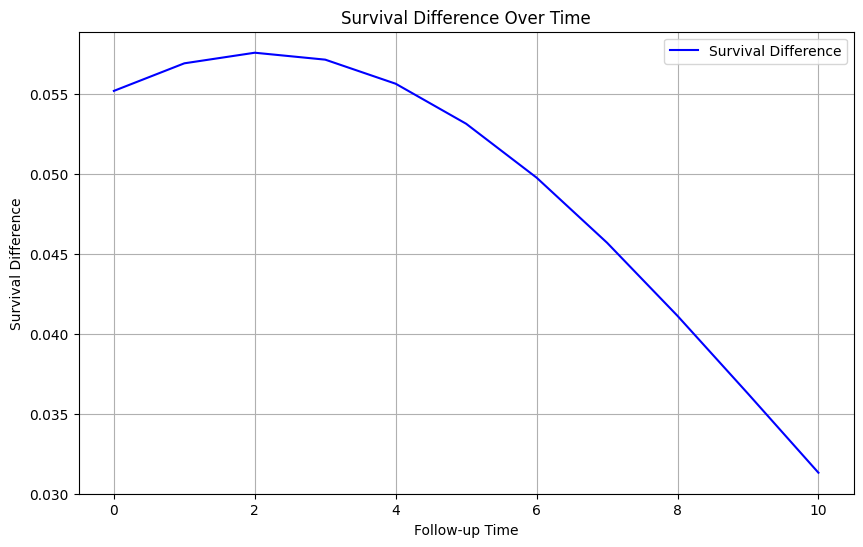

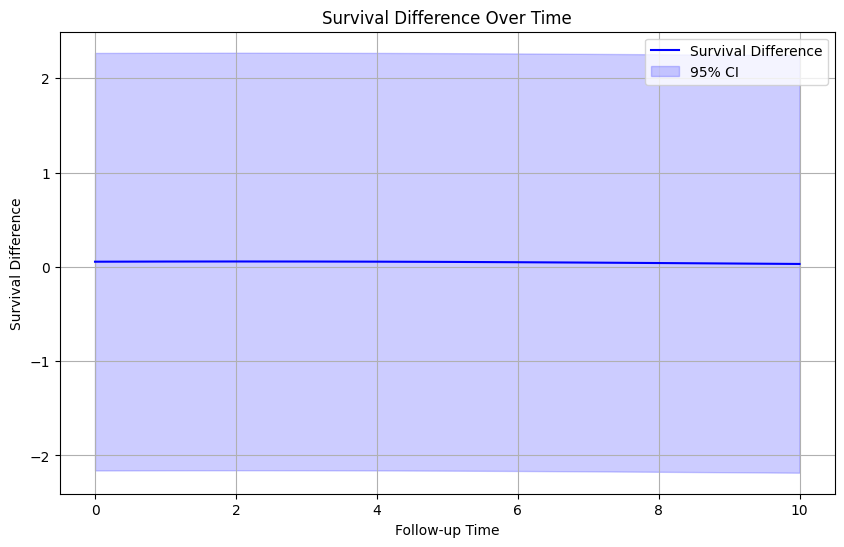

In [17]:
# Plot the survival difference
plt.figure(figsize=(10, 6))
plt.plot(preds['difference']['followup_time'], preds['difference']['survival_diff'], label="Survival Difference", color='b')
plt.xlabel("Follow-up Time")
plt.ylabel("Survival Difference")
plt.title("Survival Difference Over Time")
plt.legend()
plt.grid(True)
plt.show()

# No fill
plt.figure(figsize=(10, 6))
plt.plot(preds['difference']['followup_time'], preds['difference']['survival_diff'], label="Survival Difference", color='b')
plt.fill_between(preds['difference']['followup_time'], preds['difference']['2.5%'], preds['difference']['97.5%'], color='b', alpha=0.2, label="95% CI")
plt.xlabel("Follow-up Time")
plt.ylabel("Survival Difference")
plt.title("Survival Difference Over Time")
plt.legend()
plt.grid(True)
plt.show()


# **Conclusion**  

- **Trend Analysis:** The survival difference initially increases before declining, suggesting a diminishing effect of the intervention over time.  
- **Importance of No-CI Plot:** Removing confidence intervals clarifies the survival difference trajectory, preventing uncertainty bands from overshadowing trends.  
- **Wide Confidence Intervals:** The large CI range indicates high variability, possibly due to unmeasured confounding, small sample sizes, or treatment heterogeneity.  
- **Implications of Uncertainty:** The true effect may vary significantly, requiring sensitivity analyses or alternative modeling for stronger causal inferences.  
- **Key Takeaway:** While the no-CI plot highlights general trends, the high uncertainty suggests caution in interpretation, especially in a target trial emulation setting.